# Look at feature extraction for facial detection using HOG

HOG is a Histogram of Orientation Gradients. This notebook will build a simple face recognition capability to illustrate how this works.

* Import relevany Python libraries

In [43]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage import color, feature
import cv2
import pandas as pd
import os
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV

import sys
sys.path.append('../') 
from utils import show_side_by_side, load_image_as_array, show_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/markstrefford/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/markstrefford/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


* Load an image to work with and convert to gray scale

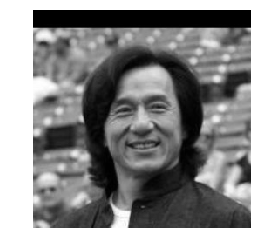

In [11]:
image = load_image_as_array('../lfw/Jackie_Chan/Jackie_Chan_0001.jpg', cv2.COLOR_BGR2GRAY)
show_image(image)


* Now perform feature extraction using HOG

In [12]:
hog_vec, hog_vis = feature.hog(image, visualise=True)

/Users/markstrefford/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


* And display side by side

(Note the 1-hog_vis makes this a black-on-white visualisation, removing the '1-' means white on black) 

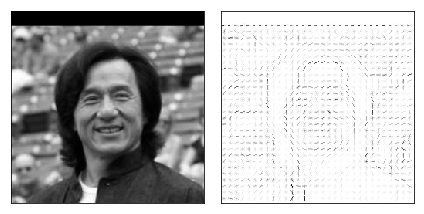

In [14]:
show_side_by_side([image, 1-hog_vis])

### Recognising Faces

* Let's create a training dataset

We'll start by getting a list of names where there are at least 10 images. Reindex the dataframe so that the index is consecutive and starts at 1.

In [41]:
df_names = pd.read_csv('../lfw/lfw-names.txt', delim_whitespace=True, names=['name', 'count'])
df_training_names = df_names[df_names['count'] >= 10].reset_index()
df_training_names.index = df_training_names.index + 1
df_training_names

,index,name,count
1,20,Abdullah_Gul,19
2,52,Adrien_Brody,12
3,127,Alejandro_Toledo,39
4,210,Alvaro_Uribe,35
5,223,Amelie_Mauresmo,21
6,248,Andre_Agassi,36
7,291,Andy_Roddick,15
8,304,Angelina_Jolie,20
9,317,Ann_Veneman,11
10,321,Anna_Kournikova,12


* Create a list of files to train with

Note that we:

1) Loads the images and create the hog vector for them.  We don't build a classifier on the raw image here.

2) Add the index to the labels (y), this is because classifiers work better on a numerical output rather than a string. 

In [63]:
X = []
y = []
lfw_dir = '../lfw'
for i, training_name in df_training_names.iterrows():
    name = training_name['name']
    files = os.listdir(os.path.join(lfw_dir, name))
    for file in files:
        image = load_image_as_array(os.path.join(lfw_dir, name, file), cv2.COLOR_BGR2GRAY)
        hog_vec = feature.hog(image)
        X.append(hog_vec)
        y.append(i)
        
X = np.array(X)
y = np.array(y)

/Users/markstrefford/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [64]:
print('Training data shape: {}'.format(X.shape))

Training data shape: (4324, 68121)


* Now we'll train our model using SVM

We'll use a number of parameters to find the best one for our classifier

In [ ]:
grid = GridSearchCV(LinearSVC(), {'C': [0.3, 1.0, 3.0, 9.0]})
grid.fit(X, y)
grid.best_score_